In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from spikingjelly.activation_based import neuron, functional, surrogate, layer
from tqdm import tqdm

In [2]:
class CSNN(nn.Module):
    def __init__(self, T: int):
        super().__init__()
        self.T = T

        self.conv_fc = nn.Sequential(
            layer.Conv2d(2, 6, kernel_size=3, padding=2, bias=False),
            layer.BatchNorm2d(6),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),

            layer.Conv2d(6, 16, kernel_size=3, padding=0, bias=False),
            layer.BatchNorm2d(16),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),

            layer.Conv2d(16, 120, kernel_size=3, padding=0, bias=False),
            layer.Flatten(),

            layer.Linear(120, 84, bias=False),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.Linear(84, 10, bias=False),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')

    def forward(self, x: torch.Tensor):
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]
        x_seq = self.conv_fc(x_seq)
        fr = x_seq.mean(0)
        return fr

class SNNLeNet(nn.Module):
    def __init__(self, T: int):
        super(SNNLeNet, self).__init__()
        self.T = T
        

        self.LeNet = nn.Sequential(
            layer.Conv2d(2, 32, kernel_size=3, stride=1, padding=2),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(kernel_size=2, stride=2),
 
            layer.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            neuron.IFNode(surrogate_function=surrogate.ATan()),

            layer.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(kernel_size=2, stride=2),
            layer.Flatten(),

            layer.Linear(64 * 7 * 7, 512),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
 
            layer.Linear(512, 10),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')

    def forward(self, x: torch.Tensor):
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]
        x_seq = self.LeNet(x_seq)
        fr = x_seq.mean(0)
        return fr

class SNNAlexNet(nn.Module):
    def __init__(self, T: int):
        super(SNNAlexNet, self).__init__()
        self.T = T
        

        self.features = nn.Sequential(
            layer.Conv2d(2, 64, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(64),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),

            layer.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            layer.BatchNorm2d(64),
            neuron.IFNode(surrogate_function=surrogate.ATan()),
            layer.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            layer.Flatten(),
            layer.Linear(64 * 7 * 7, 64 * 4 * 4, bias=False),
            neuron.IFNode(surrogate_function=surrogate.ATan()),

            layer.Linear(64 * 4 * 4, 10, bias=False),         
            neuron.IFNode(surrogate_function=surrogate.ATan()),
        )

        functional.set_step_mode(self, step_mode='m')

    def forward(self, x: torch.Tensor):
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]
        x_seq = self.features(x_seq)
        x_seq = self.classifier(x_seq)
        fr = x_seq.mean(0)
        return fr

In [3]:
T = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
total_epochs = 5
lr = 1e-3

In [4]:
# colorMNIST
def make_environment(images, labels, e):
    def torch_bernoulli(p, size):
        return (torch.rand(size) < p).float()
    def torch_xor(a, b):
        return (a - b).abs()  # Assumes both inputs are either 0 or 1
    # 2x subsample for computational convenience
    images = images.reshape((-1, 28, 28))[:, ::2, ::2]
    # Assign a binary label based on the digit; flip label with probability 0.25
    labels = (labels < 5).float()
    labels = torch_xor(labels, torch_bernoulli(0.25, len(labels)))
    # Assign a color based on the label; flip the color with probability e
    colors = torch_xor(labels, torch_bernoulli(e, len(labels)))
    # Apply the color to the image by zeroing out the other color channel
    images = torch.stack([images, images], dim=1)
    # images[torch.tensor(range(len(images))), (1 - colors).long(), :, :] *= 0
    images = images.clone()
    images[torch.tensor(range(len(images))), (1 - colors).long(), :, :] = 0
    return {
        'images': (images.float() / 255.),
        'labels': labels[:, None]
    }

In [5]:
simple_net = CSNN(T).to(device)
lenet = SNNLeNet(T).to(device)
alexnet = SNNAlexNet(T).to(device)
nets = [simple_net, lenet, alexnet]
# nets_name = ['Simple CNN', 'LeNet', 'AlexNet']
nets_name = ['Simple CNN']

train_set = torchvision.datasets.MNIST(
    root='./datasets',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_set = make_environment(train_set.data, train_set.targets, 0.2)


test_set = torchvision.datasets.MNIST(
    root='./datasets',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

test_set = make_environment(test_set.data, test_set.targets, 0.2)

train_data_loader = torch.utils.data.DataLoader(
    dataset=list(zip(train_set['images'], train_set['labels'])),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=list(zip(test_set['images'], test_set['labels'])),
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    pin_memory=True
)

simple_optimizer = torch.optim.Adam(simple_net.parameters(), lr=lr)
lenet_optimizer = torch.optim.Adam(lenet.parameters(), lr=lr)
alexnet_optimizer = torch.optim.Adam(alexnet.parameters(), lr=lr)
opts = [simple_optimizer, lenet_optimizer, alexnet_optimizer]

simple_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(simple_optimizer, total_epochs)
lenet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(lenet_optimizer, total_epochs)
alexnet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(alexnet_optimizer, total_epochs)
schedulers = [simple_scheduler, lenet_scheduler, alexnet_scheduler]

In [6]:
train_losses = [[], [], []]
train_accuracies = [[], [], []]
test_losses = [[], [], []]
test_accuracies = [[], [], []]

for i in range(1):
    print(f'Training {nets_name[i]}')
    net = nets[i]
    optimizer = opts[i]
    scheduler = schedulers[i]

    for epoch in range(1, total_epochs + 1):
        print(f'Epoch {epoch}/{total_epochs}')

        net.train()
        train_loss = 0
        train_acc = 0
        train_samples = 0

        # pbar = tqdm(train_data_loader, desc=f'Train {epoch}/{total_epochs}', leave=False)
        for img, label in train_data_loader:
            optimizer.zero_grad()          #reset optimizer
            img = img.to(device)
            label = label.to(device).long()
            label_onehot = F.one_hot(label, 10).float() #one-hot encoding the label to a vector

            # print(img.shape)
            out_fr = net(img)
            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()
            functional.reset_net(net)

            train_samples += label.numel()
            train_loss += loss.item() * label.numel()
            train_acc += (out_fr.argmax(1) == label).float().sum().item()

            functional.reset_net(net)

        train_loss /= train_samples
        train_acc /= train_samples
        train_losses[i].append(train_loss)
        train_accuracies[i].append(train_acc)
        print(f'Train Loss ={train_loss: .4f}, Train Accuracy ={train_acc: .4f}')

        scheduler.step()

        net.eval()
        test_loss = 0
        test_acc = 0
        test_samples = 0
        with torch.no_grad():
            # pbar = tqdm(test_data_loader, desc=f'Test {epoch}/{total_epochs}', leave=False)
            for img, label in test_data_loader:
                img = img.to(device)
                label = label.to(device).long()
                label_onehot = F.one_hot(label.squeeze(), 10).float()
                out_fr = net(img)
                loss = F.mse_loss(out_fr, label_onehot)

                test_samples += label.numel()
                test_loss += loss.item() * label.numel()
                test_acc += (out_fr.argmax(1) == label).float().sum().item()
                functional.reset_net(net)

        test_loss /= test_samples
        test_acc /= test_samples
        test_losses[i].append(test_loss)
        test_accuracies[i].append(test_acc)
        print(f'Test Loss ={test_loss: .4f}, Test Accuracy ={test_acc: .4f}')


Training Simple CNN
Epoch 1/5


/tmp/ipykernel_9669/2847313978.py:29: UserWarning: Using a target size (torch.Size([128, 1, 10])) that is different to the input size (torch.Size([128, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out_fr, label_onehot)


Train Loss = 0.0509, Train Accuracy = 63.2263
Test Loss = 0.0500, Test Accuracy = 63.1952
Epoch 2/5
Train Loss = 0.0502, Train Accuracy = 63.3658
Test Loss = 0.0502, Test Accuracy = 63.7752
Epoch 3/5
Train Loss = 0.0503, Train Accuracy = 63.4844
Test Loss = 0.0500, Test Accuracy = 63.2400
Epoch 4/5
Train Loss = 0.0502, Train Accuracy = 63.5136
Test Loss = 0.0500, Test Accuracy = 63.2928
Epoch 5/5
Train Loss = 0.0503, Train Accuracy = 63.5517
Test Loss = 0.0501, Test Accuracy = 63.2846


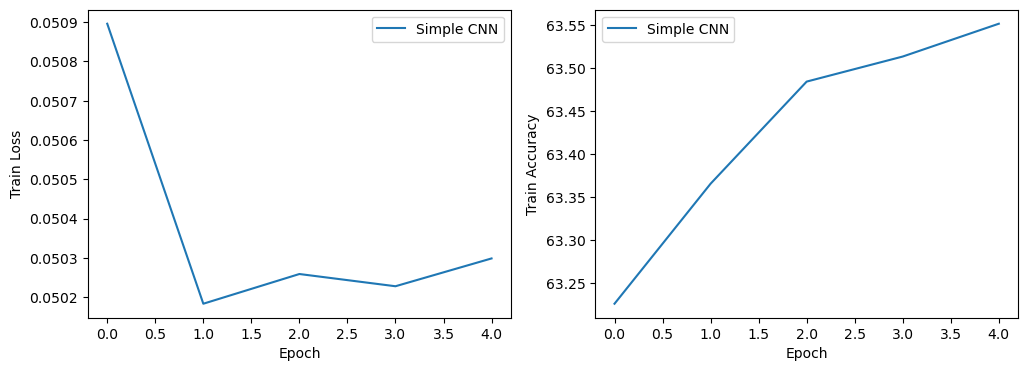

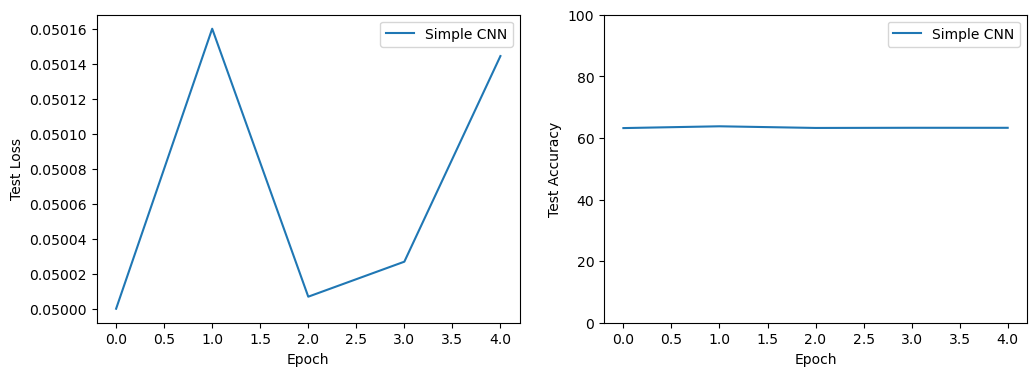

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
for i in range(1):
    plt.plot(train_losses[i], label=f'{nets_name[i]}')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.subplot(122)
for i in range(1):
    plt.plot(train_accuracies[i], label=f'{nets_name[i]}')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(121)
for i in range(1):
    plt.plot(test_losses[i], label=f'{nets_name[i]}')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.subplot(122)
for i in range(1):
    plt.plot(test_accuracies[i], label=f'{nets_name[i]}')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.ylim(0, 100)
plt.legend()
plt.show()